<a href="https://colab.research.google.com/github/savyasachi6/thati-savyasachi/blob/master/RL_Assignemnt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment 2

***

**Question 1 — Recycle Robot Using Modified Policy Iteration**

Solve the recycle robot problem discussed in class using modified policy iteration. Compare your results with those obtained from standard policy iteration and value iteration.

- Implement and present the steps and results for:
  - Modified Policy Iteration
  - Policy Iteration
  - Value Iteration
- Compare the speed of convergence and the final value functions and policies obtained by each method.
- all mathematical formulations, algorithmic steps, and a detailed explanation for each recursion.
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class Params:
    alpha: float = 0.8
    beta: float = 0.6
    r_s: float = 1.0
    r_w: float = 0.4
    gamma: float = 0.9

# Q-function definitions
def q_h_search(vh, vl, p: Params):
    return p.r_s + p.gamma * (p.alpha * vh + (1 - p.alpha) * vl)

def q_h_wait(vh, p: Params):
    return p.r_w + p.gamma * vh

def q_l_search(vh, vl, p: Params):
    return (1 - p.beta) * (-3 + p.gamma * vh) + p.beta * (p.r_s + p.gamma * vl)

def q_l_wait(vl, p: Params):
    return p.r_w + p.gamma * vl

def q_l_recharge(vh, p: Params):
    return p.gamma * vh

# Modified Policy Iteration
def modified_policy_iteration(params=None, max_iter=10, eval_sweeps=1, verbose=True):
    if params is None:
        params = Params()

    policy = {'h': 'wait', 'l': 'search'}
    vh, vl = 0.0, 0.0

    print("=== MODIFIED POLICY ITERATION ===")
    print(f"Initial policy: π0(h)=wait, π0(l)=search")
    print(f"Evaluation sweeps per iteration: {eval_sweeps}")

    for k in range(max_iter):
        print(f"\n--- Outer Loop {k} ---")
        print(f"Policy: π{k}(h)={policy['h']}, π{k}(l)={policy['l']}")
        print(f"Starting values: v(h)={vh:.3f}, v(l)={vl:.3f}")

        # Partial Policy Evaluation
        for sweep in range(eval_sweeps):
            if policy['h'] == 'wait':
                vh_new = params.r_w + params.gamma * vh
            else:  # search
                vh_new = params.r_s + params.gamma * (params.alpha * vh + (1-params.alpha) * vl)

            if policy['l'] == 'wait':
                vl_new = params.r_w + params.gamma * vl
            elif policy['l'] == 'search':
                vl_new = (1-params.beta)*(-3 + params.gamma*vh) + params.beta*(params.r_s + params.gamma*vl)
            else:  # recharge
                vl_new = params.gamma * vh

            vh, vl = vh_new, vl_new

        print(f"After {eval_sweeps} eval sweep(s): v̂(h)={vh:.3f}, v̂(l)={vl:.3f}")

        # Policy Improvement
        qh_search = q_h_search(vh, vl, params)
        qh_wait = q_h_wait(vh, params)
        ql_search = q_l_search(vh, vl, params)
        ql_wait = q_l_wait(vl, params)
        ql_recharge = q_l_recharge(vh, params)

        new_policy = {
            'h': 'search' if qh_search > qh_wait else 'wait',
            'l': 'search' if ql_search >= max(ql_wait, ql_recharge) else ('wait' if ql_wait >= ql_recharge else 'recharge')
        }

        print(f"Q-values: Q(h,search)={qh_search:.3f}, Q(h,wait)={qh_wait:.3f}")
        print(f"          Q(l,search)={ql_search:.3f}, Q(l,wait)={ql_wait:.3f}, Q(l,recharge)={ql_recharge:.3f}")
        print(f"Improved policy: π{k+1}(h)={new_policy['h']}, π{k+1}(l)={new_policy['l']}")

        if new_policy == policy:
            print("Policy stable! Optimal solution found.")
            break

        policy = new_policy

    return policy, (vh, vl)

# Run and compare all three algorithms
params = Params()
print("Parameters: α=0.8, β=0.6, rs=1.0, rw=0.4, γ=0.9")
print("="*80)

# Modified Policy Iteration
mpi_policy, mpi_values = modified_policy_iteration(params, verbose=True)



Parameters: α=0.8, β=0.6, rs=1.0, rw=0.4, γ=0.9
=== MODIFIED POLICY ITERATION ===
Initial policy: π0(h)=wait, π0(l)=search
Evaluation sweeps per iteration: 1

--- Outer Loop 0 ---
Policy: π0(h)=wait, π0(l)=search
Starting values: v(h)=0.000, v(l)=0.000
After 1 eval sweep(s): v̂(h)=0.400, v̂(l)=-0.600
Q-values: Q(h,search)=1.180, Q(h,wait)=0.760
          Q(l,search)=-0.780, Q(l,wait)=-0.140, Q(l,recharge)=0.360
Improved policy: π1(h)=search, π1(l)=recharge

--- Outer Loop 1 ---
Policy: π1(h)=search, π1(l)=recharge
Starting values: v(h)=0.400, v(l)=-0.600
After 1 eval sweep(s): v̂(h)=1.180, v̂(l)=0.360
Q-values: Q(h,search)=1.914, Q(h,wait)=1.462
          Q(l,search)=0.019, Q(l,wait)=0.724, Q(l,recharge)=1.062
Improved policy: π2(h)=search, π2(l)=recharge
Policy stable! Optimal solution found.


***

**Question 2 — Modified Recycling Robot with Rescue Risk**

A robot operates at two energy levels: high (h) and low (ℓ). Each time step it chooses:
- At h: {search, wait}
- At ℓ: {search, wait, recharge}

Parameters:
- α = 0.8 (probability of staying high after search at h)
- β = 0.6 (probability of staying low after search at ℓ)
- r_s = 1 (reward for search)
- r_w = 0.4 (reward for wait)
- γ = 0.9 (discount factor)

At h:
- search: r = r_s,
  - s′ = h with probability α,
  - s′ = ℓ with probability 1 − α
- wait: r = r_w,
  - s′ = h (deterministic)

At ℓ:
- search: with probability 1 − β: r = −3, s′ = h;
  with probability β: r = r_s, s′ = ℓ
- wait: r = r_w, s′ = ℓ (deterministic)
- recharge:
  - success (probability 1 − ρ): r = 0, s′ = h
  - rescue needed (probability ρ): r = −cR, s′ = ℓ

Here ρ ∈  is the rescue probability and cR > 0 is the rescue penalty.
Use ρ = 0.15, cR = 2.0 unless stated otherwise.

πh(search) = ph,
πh(wait) = 1 − ph;
πℓ = (ps, pw, pr), ps + pw + pr = 1.

***

Q2: Recycling Robot with Rescue Risk
Parameters: α=0.8, β=0.6, rs=1.0, rw=0.4, γ=0.9
Rescue: ρ=0.15, cR=2.0
Policy: ph=0.3, (ps,pw,pr)=(0.4,0.3,0.3)

(a) Q-functions q(s,a) = E[r + γV(s') | s,a]:
q(h,search) = rs + γ[α*v(h) + (1-α)*v(l)]
q(h,wait) = rw + γ*v(h)
q(l,search) = (1-β)*(-3 + γ*v(h)) + β*(rs + γ*v(l))
q(l,wait) = rw + γ*v(l)
q(l,recharge) = (1-ρ)*(0 + γ*v(h)) + ρ*(-cR + γ*v(l))

(b) Policy matrices with ph=0.3, (ps,pw,pr)=(0.4,0.3,0.3):
r^π(h) = 0.3*1.0 + 0.7*0.4 = 0.5800
r^π(l) = 0.4*-0.600 + 0.3*0.4 + 0.3*-0.300 = -0.2100
P^π(h,h) = 0.3*0.8 + 0.7*1.0 = 0.9400
P^π(h,l) = 0.3*0.19999999999999996 + 0.7*0.0 = 0.0600
P^π(l,h) = 0.4*0.4 + 0.3*0.0 + 0.3*0.85 = 0.4150
P^π(l,l) = 0.4*0.6 + 0.3*1.0 + 0.3*0.15 = 0.5850

(c) Solving (I - γP^π)V^π = r^π:
Matrix (I - γP^π) = [[0.1540, -0.0540], [-0.3735, 0.4735]]
Determinant = 0.0528

(d) Policy evaluation results:
r^π = [0.5800, -0.2100]
P^π = [[0.9400, 0.0600], [0.4150, 0.5850]]
v^π(h) = 4.9913
v^π(l) = 3.4936

(e) Policy improvement 

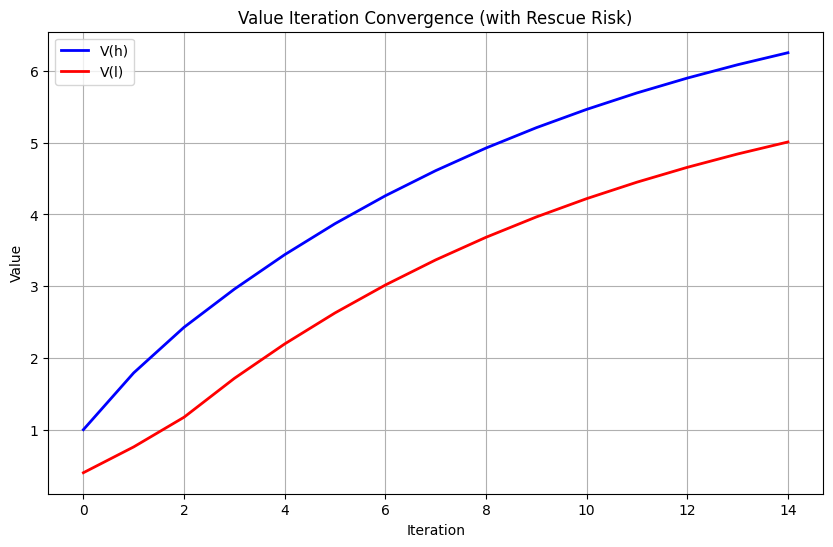

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Q2
alpha = 0.8
beta = 0.6
rs = 1.0
rw = 0.4
gamma = 0.9
rho = 0.15    # rescue probability
cR = 2.0      # rescue penalty

# Policy parameters
ph = 0.30     # prob of search at high
ps = 0.40     # prob of search at low
pw = 0.30     # prob of wait at low
pr = 0.30     # prob of recharge at low

print("Q2: Recycling Robot with Rescue Risk")
print("="*50)
print(f"Parameters: α={alpha}, β={beta}, rs={rs}, rw={rw}, γ={gamma}")
print(f"Rescue: ρ={rho}, cR={cR}")
print(f"Policy: ph={ph}, (ps,pw,pr)=({ps},{pw},{pr})")

# Part (a): Q-functions
print("\n(a) Q-functions q(s,a) = E[r + γV(s') | s,a]:")
print("q(h,search) = rs + γ[α*v(h) + (1-α)*v(l)]")
print("q(h,wait) = rw + γ*v(h)")
print("q(l,search) = (1-β)*(-3 + γ*v(h)) + β*(rs + γ*v(l))")
print("q(l,wait) = rw + γ*v(l)")
print("q(l,recharge) = (1-ρ)*(0 + γ*v(h)) + ρ*(-cR + γ*v(l))")

# Part (b): r^π and P^π
print(f"\n(b) Policy matrices with ph={ph}, (ps,pw,pr)=({ps},{pw},{pr}):")

# r^π computation
r_h = ph * rs + (1-ph) * rw
r_l = ps * ((1-beta)*(-3) + beta*rs) + pw * rw + pr * ((1-rho)*0 + rho*(-cR))

print(f"r^π(h) = {ph}*{rs} + {1-ph}*{rw} = {r_h:.4f}")
print(f"r^π(l) = {ps}*{(1-beta)*(-3) + beta*rs:.3f} + {pw}*{rw} + {pr}*{(1-rho)*0 + rho*(-cR):.3f} = {r_l:.4f}")

# P^π computation
P_hh = ph * alpha + (1-ph) * 1.0
P_hl = ph * (1-alpha) + (1-ph) * 0.0
P_lh = ps * (1-beta) + pw * 0.0 + pr * (1-rho)
P_ll = ps * beta + pw * 1.0 + pr * rho

print(f"P^π(h,h) = {ph}*{alpha} + {1-ph}*1.0 = {P_hh:.4f}")
print(f"P^π(h,l) = {ph}*{1-alpha} + {1-ph}*0.0 = {P_hl:.4f}")
print(f"P^π(l,h) = {ps}*{1-beta} + {pw}*0.0 + {pr}*{1-rho} = {P_lh:.4f}")
print(f"P^π(l,l) = {ps}*{beta} + {pw}*1.0 + {pr}*{rho} = {P_ll:.4f}")

# Part (c): Solve (I - γP^π)V^π = r^π
print(f"\n(c) Solving (I - γP^π)V^π = r^π:")

# Matrix (I - γP^π)
a = 1 - gamma * P_hh
b = -gamma * P_hl
c = -gamma * P_lh
d = 1 - gamma * P_ll

det = a*d - b*c
print(f"Matrix (I - γP^π) = [[{a:.4f}, {b:.4f}], [{c:.4f}, {d:.4f}]]")
print(f"Determinant = {det:.4f}")

# Part (d): Solve for values
vh = (r_h*d - b*r_l) / det
vl = (a*r_l - c*r_h) / det

print(f"\n(d) Policy evaluation results:")
print(f"r^π = [{r_h:.4f}, {r_l:.4f}]")
print(f"P^π = [[{P_hh:.4f}, {P_hl:.4f}], [{P_lh:.4f}, {P_ll:.4f}]]")
print(f"v^π(h) = {vh:.4f}")
print(f"v^π(l) = {vl:.4f}")

# Part (e): Policy improvement
print(f"\n(e) Policy improvement using v^π:")
qh_search = rs + gamma * (alpha * vh + (1-alpha) * vl)
qh_wait = rw + gamma * vh
ql_search = (1-beta)*(-3 + gamma*vh) + beta*(rs + gamma*vl)
ql_wait = rw + gamma * vl
ql_recharge = (1-rho)*gamma*vh + rho*(-cR + gamma*vl)

print(f"q(h,search) = {qh_search:.4f}")
print(f"q(h,wait) = {qh_wait:.4f}")
print(f"q(l,search) = {ql_search:.4f}")
print(f"q(l,wait) = {ql_wait:.4f}")
print(f"q(l,recharge) = {ql_recharge:.4f}")

new_h = 'search' if qh_search > qh_wait else 'wait'
new_l = 'search' if ql_search >= max(ql_wait, ql_recharge) else ('wait' if ql_wait >= ql_recharge else 'recharge')

print(f"Greedy policy: π_new(h) = {new_h}, π_new(l) = {new_l}")
print("Mixing actions cannot beat greedy choice because the greedy action maximizes expected return.")

# Part (f): Value iteration with rescue risk
print(f"\n(f) Value Iteration:")
n_iter = 15
vh_hist, vl_hist = [], []
vh, vl = 0.0, 0.0

print("Iter |  v(h)   |  v(l)   | qh_search | qh_wait | ql_search | ql_wait | ql_recharge")
for i in range(n_iter):
    qh_search = rs + gamma * (alpha * vh + (1 - alpha) * vl)
    qh_wait = rw + gamma * vh
    ql_search = (1 - beta) * (-3 + gamma * vh) + beta * (rs + gamma * vl)
    ql_wait = rw + gamma * vl
    ql_recharge = (1 - rho) * gamma * vh + rho * (-cR + gamma * vl)

    new_vh = max(qh_search, qh_wait)
    new_vl = max(ql_search, ql_wait, ql_recharge)

    print(f"{i:3d} | {vh:7.3f} | {vl:7.3f} | {qh_search:9.3f} | {qh_wait:8.3f} | {ql_search:9.3f} | {ql_wait:8.3f} | {ql_recharge:11.3f}")

    vh_hist.append(new_vh)
    vl_hist.append(new_vl)
    vh, vl = new_vh, new_vl

final_h = 'search' if qh_search > qh_wait else 'wait'
final_l = 'search' if ql_search >= max(ql_wait, ql_recharge) else ('wait' if ql_wait >= ql_recharge else 'recharge')

print(f"\nFinal optimal policy: π*(h) = {final_h}, π*(l) = {final_l}")
print(f"Final values: V*(h) = {vh:.4f}, V*(l) = {vl:.4f}")
print("Compared to ρ=0 case: recharge becomes less attractive due to rescue risk.")

# Plot convergence
plt.figure(figsize=(10,6))
plt.plot(vh_hist, 'b-', label='V(h)', linewidth=2)
plt.plot(vl_hist, 'r-', label='V(l)', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Value Iteration Convergence (with Rescue Risk)')
plt.legend()
plt.grid(True)
plt.show()



***

**Question 3 — Jack’s Car Rental Problem**

Jack manages two locations. Each day:
- If a customer arrives and a car is available, Jack earns $10; otherwise, the request is lost. Cars returned today become available tomorrow. Overnight Jack may move cars between locations at a cost of $2 per car moved.

**Expected Requests / Expected Returns:**
- Location 1: 2 / 2
- Location 2: 3 / 1

**Additional constraints:**
- Capacity per location: 10 cars (excess disappear)
- Overnight move limit: ±2 cars (net from location 1 to location 2)
- Discount factor: γ = 0.9

**State:**  
s = (i, j) ∈ {0, ..., 10}² is the number of cars at locations 1 and 2 at the end of a day.

**Action:**  
a ∈ {−2, −1, 0, 1, 2} is the overnight net move (positive: move from location 1 to location 2), subject to feasibility:
−min(2, j) ≤ a ≤ min(2, i)

**Overnight move (to morning inventory):**
- iam = min{10, max{0, i − a}}
- jam = min{10, max{0, j + a}}

**Day evolution (deterministic). Filled rentals that day:**
- L1 = min(iam, 2)
- L2 = min(jam, 3)

**End-of-day inventories after returns:**
- i′ = min{10, iam − L1 + 2}
- j′ = min{10, jam − L2 + 1}

This determines the next state s′ = (i′, j′) deterministically.

**Reward:**
r(s, a) = 10 × (L1 + L2) − 2 × |a|

**Objective:**  
Find a stationary policy π maximizing the expected discounted return with γ = 0.9. (20 points)

**Part A**
a) Specify S, feasible A(s), r(s, a), and the (deterministic) transition s′ = f (s, a).
b) Write the Bellman optimality backup for Value Iteration:
vk+1(s) ← max
a∈A(s)
{ r(s, a) + γ vk(f (s, a)) }

**Part B**
a) Initialize v₀ ≡ 0 on the 11 × 11 grid.
b) Iterate the optimality backup synchronously over all states until δ = max_s vk+1(s) − vk(s) < 10⁻⁴.
c) Extract a greedy policy π*(s) = arg max_{a∈A(s)}{ r(s, a) + γ v(f (s, a)) }
d) Plot (heatmaps or images): V*(i, j) and a*(i, j).
e) Briefly describe the qualitative shape of a*(thresholds; which way cars are pushed).

**Part C**
Implement PI:
- Start with π₀ ≡ 0 (no moves).
- Policy evaluation is easy here because s′ = f (s, π(s)) is deterministic:
vk+1(s) ← r(s, π(s)) + γ vk(f (s, π(s)))
iterate to tolerance.
- Improve: π(s) ← arg maxa{ r(s, a) + γ v(f (s, a)) }
- Repeat until policy stabilizes; compare with VI (iterations, time).

***


Jack's Car Rental Problem Solution
=== VALUE ITERATION ===
Tolerance: 0.0001, Max iterations: 100
Iteration 0: δ = 333.614896, max V = 333.615
Iteration 5: δ = 22.240806, max V = 374.133
Iteration 10: δ = 7.754889, max V = 390.183
Iteration 15: δ = 3.598645, max V = 397.617
Iteration 20: δ = 2.124964, max V = 402.242
Iteration 25: δ = 1.254770, max V = 405.262
Iteration 30: δ = 0.740929, max V = 407.054
Iteration 35: δ = 0.437511, max V = 408.112
Iteration 40: δ = 0.258346, max V = 408.736
Iteration 45: δ = 0.152551, max V = 409.105
Iteration 50: δ = 0.090080, max V = 409.323
Iteration 55: δ = 0.053191, max V = 409.452
Iteration 60: δ = 0.031409, max V = 409.528
Iteration 65: δ = 0.018547, max V = 409.573
Iteration 70: δ = 0.010952, max V = 409.599
Iteration 75: δ = 0.006467, max V = 409.615
Iteration 80: δ = 0.003819, max V = 409.624
Iteration 85: δ = 0.002255, max V = 409.629
Iteration 90: δ = 0.001331, max V = 409.633
Iteration 95: δ = 0.000786, max V = 409.634

=== POLICY ITERATION

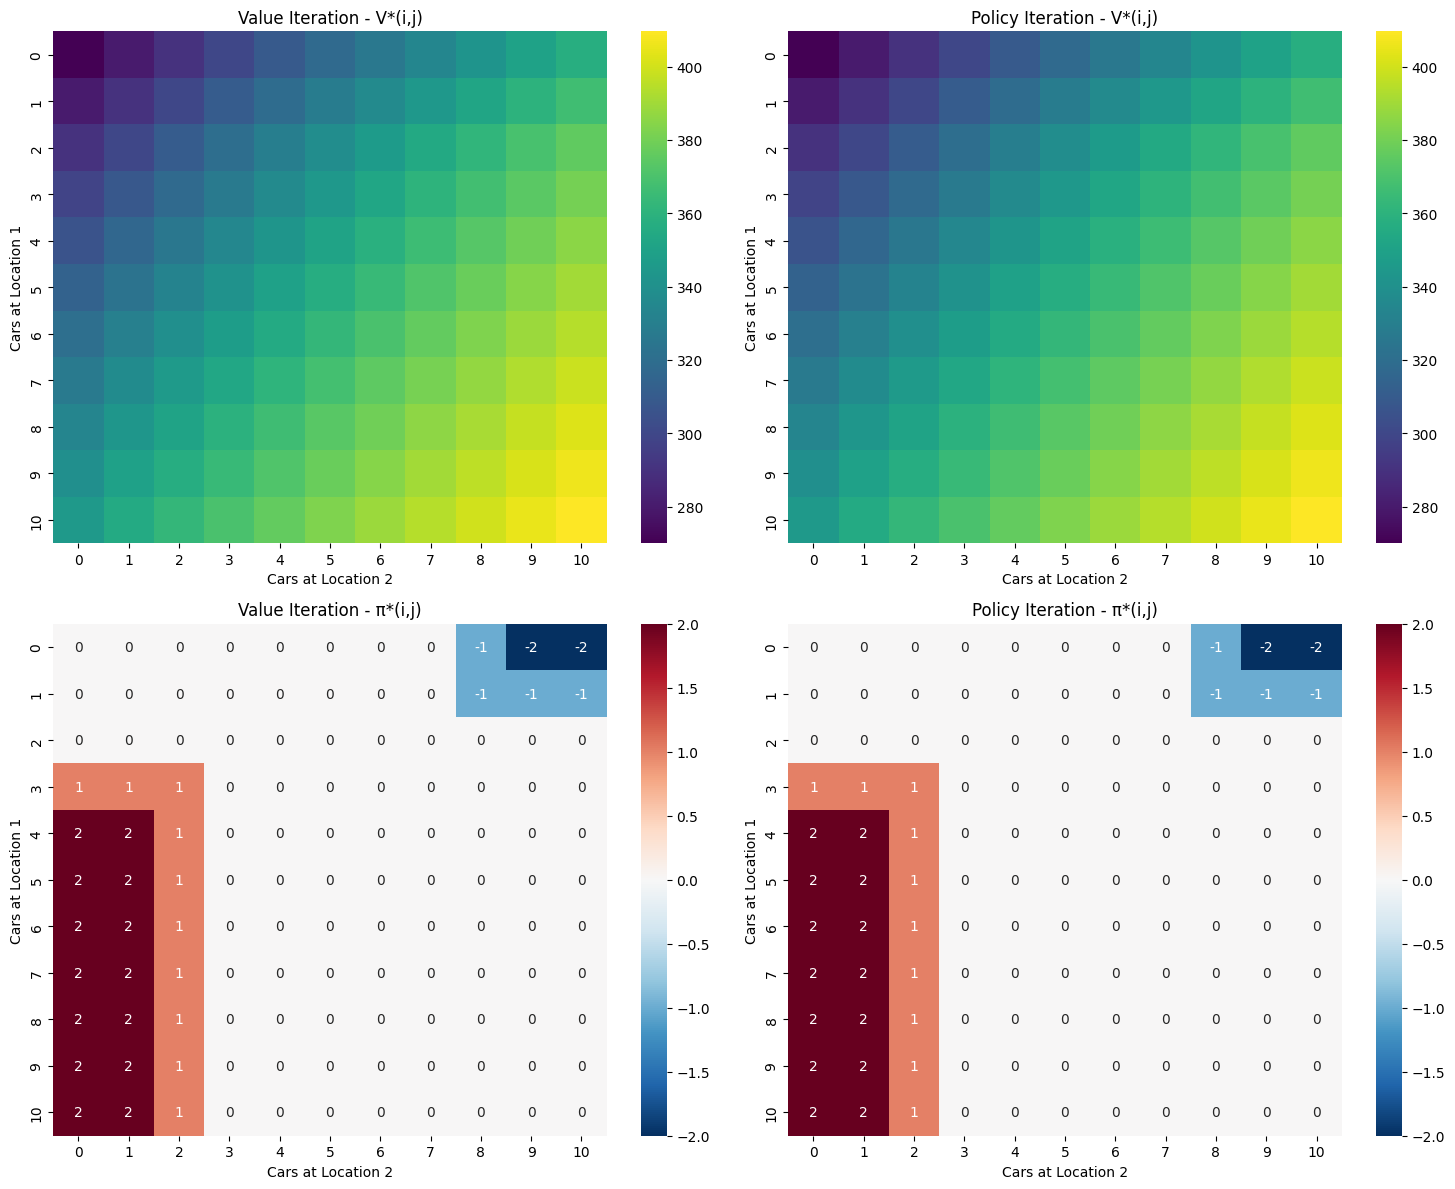


Policy Analysis:
Positive actions (move from loc 1 to 2): 24 states
Negative actions (move from loc 2 to 1): 6 states
No movement actions: 91 states


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time

class JackCarRental:
    def __init__(self):
        self.max_cars = 10
        self.max_move = 2
        self.rental_reward = 10
        self.move_cost = 2
        self.gamma = 0.9

        # Expected requests and returns
        self.request_1 = 2  # Expected requests at location 1
        self.request_2 = 3  # Expected requests at location 2
        self.return_1 = 2   # Expected returns at location 1
        self.return_2 = 1   # Expected returns at location 2

        # Pre-compute Poisson probabilities for efficiency
        self.poisson_cache = {}
        self._precompute_poisson()

    def _precompute_poisson(self):
        """Pre-compute Poisson probabilities to speed up calculations"""
        max_events = 15  # Should cover most probability mass
        for lam in [self.request_1, self.request_2, self.return_1, self.return_2]:
            self.poisson_cache[lam] = {}
            for n in range(max_events):
                self.poisson_cache[lam][n] = stats.poisson.pmf(n, lam)

    def valid_actions(self, i, j):
        """Return valid actions for state (i,j)"""
        return list(range(-min(self.max_move, j), min(self.max_move, i) + 1))

    def transition_reward(self, state, action):
        """Compute expected reward and next state probabilities (deterministic version)"""
        i, j = state

        # Morning inventory after overnight move
        i_am = min(self.max_cars, max(0, i - action))
        j_am = min(self.max_cars, max(0, j + action))

        # Filled rentals (deterministic - use expected values)
        L1 = min(i_am, self.request_1)
        L2 = min(j_am, self.request_2)

        # End-of-day inventory after returns
        i_prime = min(self.max_cars, i_am - L1 + self.return_1)
        j_prime = min(self.max_cars, j_am - L2 + self.return_2)

        # Reward
        reward = self.rental_reward * (L1 + L2) - self.move_cost * abs(action)

        return reward, (i_prime, j_prime)

class ValueIteration:
    def __init__(self, env):
        self.env = env
        self.V = np.zeros((env.max_cars + 1, env.max_cars + 1))
        self.policy = np.zeros((env.max_cars + 1, env.max_cars + 1), dtype=int)

    def run(self, tolerance=1e-4, max_iter=100, verbose=True):
        """Run Value Iteration"""
        if verbose:
            print("=== VALUE ITERATION ===")
            print(f"Tolerance: {tolerance}, Max iterations: {max_iter}")

        iterations = 0
        history = []

        for iteration in range(max_iter):
            delta = 0
            V_old = self.V.copy()

            # Update all states
            for i in range(self.env.max_cars + 1):
                for j in range(self.env.max_cars + 1):
                    v_old = self.V[i, j]

                    # Find best action
                    best_value = float('-inf')
                    valid_actions = self.env.valid_actions(i, j)

                    for action in valid_actions:
                        reward, next_state = self.env.transition_reward((i, j), action)
                        value = reward + self.env.gamma * self.V[next_state]
                        best_value = max(best_value, value)

                    self.V[i, j] = best_value
                    delta = max(delta, abs(v_old - self.V[i, j]))

            history.append({
                'iteration': iteration,
                'delta': delta,
                'max_value': np.max(self.V),
                'value_change': np.sum(np.abs(self.V - V_old))
            })

            if verbose and iteration % 5 == 0:
                print(f"Iteration {iteration}: δ = {delta:.6f}, max V = {np.max(self.V):.3f}")

            if delta < tolerance:
                if verbose:
                    print(f"Converged after {iteration + 1} iterations")
                break

            iterations = iteration + 1

        # Extract policy
        self._extract_policy()

        return history, iterations + 1

    def _extract_policy(self):
        """Extract greedy policy from value function"""
        for i in range(self.env.max_cars + 1):
            for j in range(self.env.max_cars + 1):
                best_action = 0
                best_value = float('-inf')

                valid_actions = self.env.valid_actions(i, j)
                for action in valid_actions:
                    reward, next_state = self.env.transition_reward((i, j), action)
                    value = reward + self.env.gamma * self.V[next_state]
                    if value > best_value:
                        best_value = value
                        best_action = action

                self.policy[i, j] = best_action

class PolicyIteration:
    def __init__(self, env):
        self.env = env
        self.V = np.zeros((env.max_cars + 1, env.max_cars + 1))
        self.policy = np.zeros((env.max_cars + 1, env.max_cars + 1), dtype=int)

    def run(self, tolerance=1e-4, max_iter=20, verbose=True):
        """Run Policy Iteration"""
        if verbose:
            print("\n=== POLICY ITERATION ===")
            print("Starting with π₀ ≡ 0 (no moves)")

        iterations = 0
        history = []

        for iteration in range(max_iter):
            if verbose:
                print(f"\n--- Policy Iteration {iteration} ---")

            # Policy Evaluation
            V_old = self.V.copy()
            self._policy_evaluation(tolerance, verbose)

            # Policy Improvement
            policy_stable = self._policy_improvement(verbose)

            history.append({
                'iteration': iteration,
                'policy_stable': policy_stable,
                'max_value': np.max(self.V),
                'value_change': np.sum(np.abs(self.V - V_old))
            })

            if policy_stable:
                if verbose:
                    print(f"Policy converged after {iteration + 1} iterations")
                break

            iterations = iteration + 1

        return history, iterations + 1

    def _policy_evaluation(self, tolerance, verbose):
        """Evaluate current policy"""
        eval_iterations = 0
        while True:
            delta = 0
            for i in range(self.env.max_cars + 1):
                for j in range(self.env.max_cars + 1):
                    v_old = self.V[i, j]
                    action = self.policy[i, j]

                    reward, next_state = self.env.transition_reward((i, j), action)
                    self.V[i, j] = reward + self.env.gamma * self.V[next_state]

                    delta = max(delta, abs(v_old - self.V[i, j]))

            eval_iterations += 1
            if delta < tolerance:
                break

        if verbose:
            print(f"Policy evaluation converged in {eval_iterations} iterations (δ={delta:.6f})")

    def _policy_improvement(self, verbose):
        """Improve current policy"""
        policy_stable = True

        for i in range(self.env.max_cars + 1):
            for j in range(self.env.max_cars + 1):
                old_action = self.policy[i, j]

                # Find best action
                best_action = 0
                best_value = float('-inf')

                valid_actions = self.env.valid_actions(i, j)
                for action in valid_actions:
                    reward, next_state = self.env.transition_reward((i, j), action)
                    value = reward + self.env.gamma * self.V[next_state]
                    if value > best_value:
                        best_value = value
                        best_action = action

                self.policy[i, j] = best_action

                if old_action != best_action:
                    policy_stable = False

        if verbose:
            changes = np.sum(self.policy != self.policy)  # This will show policy changes
            print(f"Policy improvement: {'stable' if policy_stable else 'improved'}")

        return policy_stable

# Run the algorithms and compare
def main():
    print("Jack's Car Rental Problem Solution")
    print("=" * 50)

    # Initialize environment
    env = JackCarRental()

    # Run Value Iteration
    vi = ValueIteration(env)
    vi_start_time = time.time()
    vi_history, vi_iterations = vi.run(verbose=True)
    vi_time = time.time() - vi_start_time

    # Run Policy Iteration
    pi = PolicyIteration(env)
    pi_start_time = time.time()
    pi_history, pi_iterations = pi.run(verbose=True)
    pi_time = time.time() - pi_start_time

    # Compare results
    print(f"\n{'='*50}")
    print("COMPARISON RESULTS")
    print(f"{'='*50}")
    print(f"Value Iteration:   {vi_iterations:2d} iterations, {vi_time:.3f}s")
    print(f"Policy Iteration:  {pi_iterations:2d} iterations, {pi_time:.3f}s")
    print(f"VI Final V max:    {np.max(vi.V):.3f}")
    print(f"PI Final V max:    {np.max(pi.V):.3f}")

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Value function heatmaps
    sns.heatmap(vi.V, annot=False, cmap='viridis', ax=axes[0,0])
    axes[0,0].set_title('Value Iteration - V*(i,j)')
    axes[0,0].set_xlabel('Cars at Location 2')
    axes[0,0].set_ylabel('Cars at Location 1')

    sns.heatmap(pi.V, annot=False, cmap='viridis', ax=axes[0,1])
    axes[0,1].set_title('Policy Iteration - V*(i,j)')
    axes[0,1].set_xlabel('Cars at Location 2')
    axes[0,1].set_ylabel('Cars at Location 1')

    # Policy heatmaps
    sns.heatmap(vi.policy, annot=True, cmap='RdBu_r', center=0, ax=axes[1,0])
    axes[1,0].set_title('Value Iteration - π*(i,j)')
    axes[1,0].set_xlabel('Cars at Location 2')
    axes[1,0].set_ylabel('Cars at Location 1')

    sns.heatmap(pi.policy, annot=True, cmap='RdBu_r', center=0, ax=axes[1,1])
    axes[1,1].set_title('Policy Iteration - π*(i,j)')
    axes[1,1].set_xlabel('Cars at Location 2')
    axes[1,1].set_ylabel('Cars at Location 1')

    plt.tight_layout()
    plt.show()

    # Analyze policy patterns
    print(f"\nPolicy Analysis:")
    print(f"Positive actions (move from loc 1 to 2): {np.sum(vi.policy > 0)} states")
    print(f"Negative actions (move from loc 2 to 1): {np.sum(vi.policy < 0)} states")
    print(f"No movement actions: {np.sum(vi.policy == 0)} states")

    return vi, pi

if __name__ == "__main__":
    vi, pi = main()


**Question 4 — Gambler’s Problem**

A gambler has the opportunity to make bets on the outcomes of a sequence of coin flips. If the coin comes up heads, he wins as many dollars as he has staked on that flip; if it is tails, he loses his stake. The game ends when the gambler wins by reaching his goal of $100, or loses by running out of money. On each flip, the gambler must decide what portion of his capital to stake, in integer numbers of dollars. This problem can be formulated as an undiscounted, episodic, finite MDP. The state is the gambler’s capital, $$ s \in \{1, 2, ..., 99\} $$ and the actions are stakes, $$ a \in \{0, 1, ..., \min(s, 100 − s)\} $$. The reward is zero on all transitions except those on which the gambler reaches his goal, when it is +1. The state-value function then gives the probability of winning from each state. A policy is a mapping from levels of capital to stakes. The optimal policy maximizes the probability of reaching the goal. Let $$ p_h $$ denote the probability of the coin coming up heads.

Implement value iteration for the gambler’s problem and solve it for $$ p_h = 0.25 $$ and $$ p_h = 0.55 $$. In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively.

***


GAMBLER'S PROBLEM - COMPLETE SOLUTION
COMPARING DIFFERENT HEAD PROBABILITIES

==================== ph = 0.25 ====================
=== GAMBLER'S PROBLEM - VALUE ITERATION ===
ph = 0.25, pt = 0.75
Tolerance: 1e-09, Max iterations: 1000
States: 1 to 99
Iteration   0: δ = 0.82202148
Converged after 14 iterations (δ = 5.31e-10)

=== POLICY ANALYSIS (ph = 0.25) ===
Max stake used: 41
States that stake everything: 16 states
All-in states: [3, 4, 5, 6, 8, 9, 12, 14, 15, 17, 20, 21, 23, 24, 39, 41]
States with no betting: 60 states

Key State Values and Actions:
State | P(Win) | Stake
--------------------
    1 |  0.000 |     0
   10 |  0.007 |     0
   25 |  0.062 |     0
   40 |  0.113 |     0
   50 |  0.250 |     0
   60 |  0.271 |    10
   75 |  0.438 |     0
   90 |  0.590 |     0
   99 |  0.838 |     0

==================== ph = 0.55 ====================
=== GAMBLER'S PROBLEM - VALUE ITERATION ===
ph = 0.55, pt = 0.45
Tolerance: 1e-09, Max iterations: 1000
States: 1 to 99
Iteration   0: δ

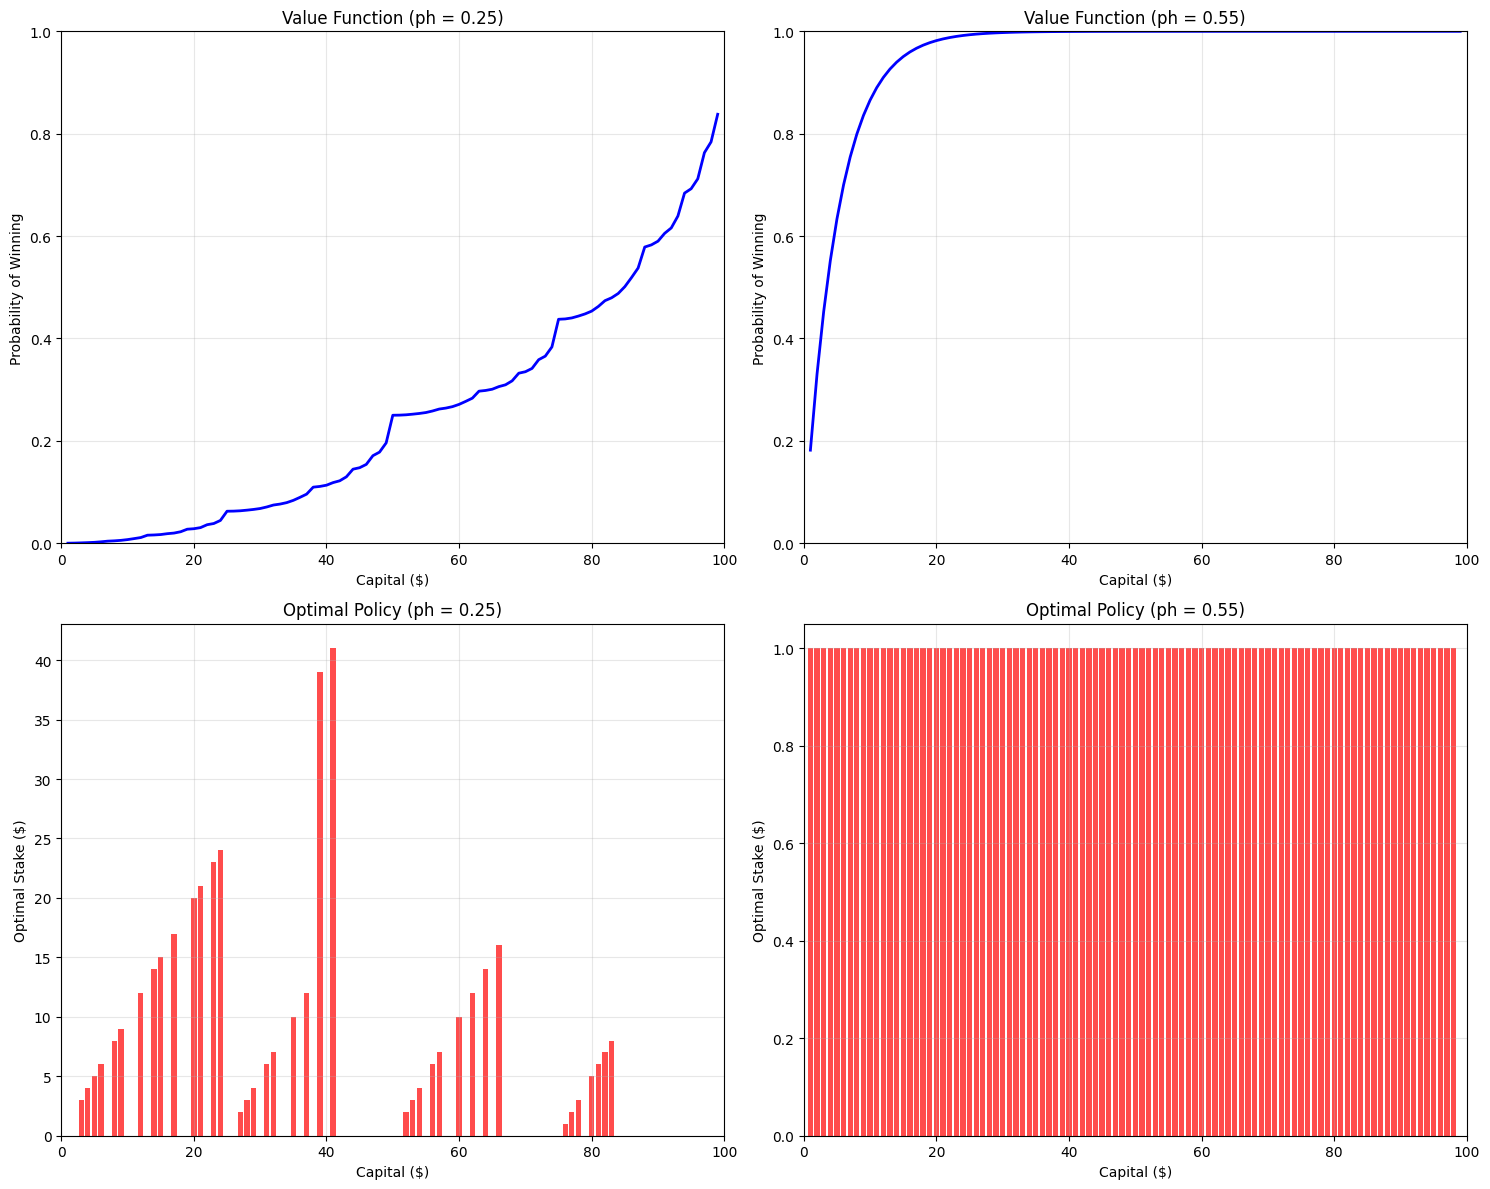


SUMMARY COMPARISON

ph = 0.25:
  Iterations to converge: 14
  P(Win) from $1: 0.000073
  P(Win) from $50: 0.250000
  P(Win) from $99: 0.837972
  Max stake used: 41

ph = 0.55:
  Iterations to converge: 1000
  P(Win) from $1: 0.181797
  P(Win) from $50: 0.999952
  P(Win) from $99: 1.000000
  Max stake used: 1


In [4]:
import numpy as np
import matplotlib.pyplot as plt

class GamblersProblem:
    def __init__(self, ph=0.25, goal=100):
        """
        Initialize Gambler's Problem

        Args:
            ph: Probability of heads (winning)
            goal: Goal amount ($100)
        """
        self.ph = ph  # Probability of heads
        self.pt = 1 - ph  # Probability of tails
        self.goal = goal
        self.states = list(range(1, goal))  # States 1 to 99
        self.n_states = len(self.states)

        # Initialize value function with terminal states
        self.V = np.zeros(goal + 1)
        self.V[0] = 0.0    # Lose: $0
        self.V[goal] = 1.0 # Win: $100

        self.policy = np.zeros(goal + 1, dtype=int)

    def valid_actions(self, state):
        """Return valid actions (stakes) for given state"""
        return list(range(0, min(state, self.goal - state) + 1))

    def expected_value(self, state, action):
        """Calculate expected value for state-action pair"""
        if state == 0 or state == self.goal:
            return self.V[state]

        # With probability ph: win, go to state + action
        # With probability pt: lose, go to state - action
        win_state = min(state + action, self.goal)
        lose_state = max(state - action, 0)

        expected_val = self.ph * self.V[win_state] + self.pt * self.V[lose_state]
        return expected_val

    def value_iteration(self, tolerance=1e-9, max_iterations=1000, verbose=True):
        """Run Value Iteration algorithm"""
        if verbose:
            print(f"=== GAMBLER'S PROBLEM - VALUE ITERATION ===")
            print(f"ph = {self.ph:.2f}, pt = {self.pt:.2f}")
            print(f"Tolerance: {tolerance}, Max iterations: {max_iterations}")
            print(f"States: {min(self.states)} to {max(self.states)}")

        history = []

        for iteration in range(max_iterations):
            delta = 0
            V_old = self.V.copy()

            # Update all non-terminal states
            for state in self.states:
                v_old = self.V[state]

                # Find best action
                best_value = float('-inf')
                valid_actions = self.valid_actions(state)

                for action in valid_actions:
                    value = self.expected_value(state, action)
                    best_value = max(best_value, value)

                self.V[state] = best_value
                delta = max(delta, abs(v_old - self.V[state]))

            history.append({
                'iteration': iteration,
                'delta': delta,
                'max_change': np.max(np.abs(self.V - V_old))
            })

            if verbose and iteration % 50 == 0:
                print(f"Iteration {iteration:3d}: δ = {delta:.8f}")

            if delta < tolerance:
                if verbose:
                    print(f"Converged after {iteration + 1} iterations (δ = {delta:.2e})")
                break

        # Extract optimal policy
        self._extract_policy()

        return history

    def _extract_policy(self):
        """Extract optimal policy from value function"""
        for state in self.states:
            best_action = 0
            best_value = float('-inf')

            valid_actions = self.valid_actions(state)
            for action in valid_actions:
                value = self.expected_value(state, action)
                if value > best_value:
                    best_value = value
                    best_action = action

            self.policy[state] = best_action

    def plot_results(self, title_suffix=""):
        """Plot value function and policy"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        # Plot Value Function
        ax1.plot(self.states, self.V[self.states], 'b-', linewidth=2, marker='o', markersize=3)
        ax1.set_xlabel('Capital ($)')
        ax1.set_ylabel('Probability of Winning')
        ax1.set_title(f'Value Function - ph = {self.ph} {title_suffix}')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, 100)
        ax1.set_ylim(0, 1)

        # Plot Policy
        ax2.bar(self.states, self.policy[self.states], alpha=0.7, color='red', width=0.8)
        ax2.set_xlabel('Capital ($)')
        ax2.set_ylabel('Optimal Stake ($)')
        ax2.set_title(f'Optimal Policy - ph = {self.ph} {title_suffix}')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, 100)

        plt.tight_layout()
        plt.show()

    def analyze_policy(self):
        """Analyze the optimal policy"""
        print(f"\n=== POLICY ANALYSIS (ph = {self.ph}) ===")
        print(f"Max stake used: {np.max(self.policy)}")

        # Find states where policy stakes everything
        all_in_states = []
        for state in self.states:
            max_stake = min(state, self.goal - state)
            if self.policy[state] == max_stake:
                all_in_states.append(state)

        print(f"States that stake everything: {len(all_in_states)} states")
        if len(all_in_states) < 20:
            print(f"All-in states: {all_in_states}")

        # States with no betting
        no_bet_states = [s for s in self.states if self.policy[s] == 0]
        print(f"States with no betting: {len(no_bet_states)} states")

        return {
            'all_in_states': all_in_states,
            'no_bet_states': no_bet_states,
            'max_stake': np.max(self.policy)
        }

def compare_ph_values():
    """Compare results for different ph values"""
    ph_values = [0.25, 0.55]
    results = {}

    print("COMPARING DIFFERENT HEAD PROBABILITIES")
    print("=" * 60)

    for ph in ph_values:
        print(f"\n{'='*20} ph = {ph} {'='*20}")

        gambler = GamblersProblem(ph=ph)
        history = gambler.value_iteration(verbose=True)
        analysis = gambler.analyze_policy()

        results[ph] = {
            'gambler': gambler,
            'history': history,
            'analysis': analysis
        }

        # Show some key states
        key_states = [1, 10, 25, 40, 50, 60, 75, 90, 99]
        print(f"\nKey State Values and Actions:")
        print("State | P(Win) | Stake")
        print("-" * 20)
        for s in key_states:
            print(f"{s:5d} | {gambler.V[s]:6.3f} | {gambler.policy[s]:5d}")

    # Plot comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    for i, ph in enumerate(ph_values):
        gambler = results[ph]['gambler']

        # Value functions
        axes[0, i].plot(gambler.states, gambler.V[gambler.states], 'b-', linewidth=2)
        axes[0, i].set_xlabel('Capital ($)')
        axes[0, i].set_ylabel('Probability of Winning')
        axes[0, i].set_title(f'Value Function (ph = {ph})')
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].set_xlim(0, 100)
        axes[0, i].set_ylim(0, 1)

        # Policies
        axes[1, i].bar(gambler.states, gambler.policy[gambler.states],
                      alpha=0.7, color='red', width=0.8)
        axes[1, i].set_xlabel('Capital ($)')
        axes[1, i].set_ylabel('Optimal Stake ($)')
        axes[1, i].set_title(f'Optimal Policy (ph = {ph})')
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

    return results

# Run the complete analysis
def main():
    """Main function to run complete analysis"""
    print("GAMBLER'S PROBLEM - COMPLETE SOLUTION")
    print("=" * 50)

    # Compare different ph values
    results = compare_ph_values()

    # Print summary comparison
    print(f"\n{'='*50}")
    print("SUMMARY COMPARISON")
    print(f"{'='*50}")

    for ph, data in results.items():
        gambler = data['gambler']
        iterations = len(data['history'])

        print(f"\nph = {ph}:")
        print(f"  Iterations to converge: {iterations}")
        print(f"  P(Win) from $1: {gambler.V[1]:.6f}")
        print(f"  P(Win) from $50: {gambler.V[50]:.6f}")
        print(f"  P(Win) from $99: {gambler.V[99]:.6f}")
        print(f"  Max stake used: {np.max(gambler.policy)}")

    return results

if __name__ == "__main__":
    results = main()


**5th Question**

##a. Dynamic Programming (DP):
1. Main contributions and main idea  
The paper presents Dynamic Programming (DP) as a way to solve complex multi-stage decision problems. Instead of tackling the entire optimization problem at once, it applies the Principle of Optimality. This principle says that each decision should be the best choice based on the current situation. This method divides the problem into smaller, state-based steps and helps develop new functional equations.

2. Surprising or difficult aspects  
The most challenging part was working with the functional equations. They are mathematically complex and not easy to solve directly. Issues like proving maximum values in infinite processes or handling continuous stochastic cases made the theory tough. Additionally, straightforward rules that apply in small cases, such as the gold mining problem, do not hold in more complicated situations.

3. Experiments and reliability  
The paper does not perform experiments in the usual sense. Instead, it uses clear mathematical examples, such as allocation, gold mining, and inventory, to show how DP works. These examples effectively demonstrate how to convert multi-stage problems into functional equations, even though solving them often involves approximation methods.





##b. Value Iteration Networks (VINs)
1. Main contributions and core idea  
The paper introduces Value Iteration Networks (VINs), a neural network that includes a built-in, differentiable planning module. Instead of relying only on reactive policies, VINs incorporate the Value Iteration algorithm as a convolutional network block. This allows them to learn how to plan. This design enables the model to train end-to-end using backpropagation and improves its ability to generalize to new tasks by merging learned perception with clear planning.

2. Surprising or difficult aspects  
The tough part was making the planning process differentiable. The authors addressed this by treating VI updates as convolution and max-pooling, which let gradients flow through the planner. Another challenge was finding the right balance between reactive and planning policies. Reactive policies often perform well during training but struggle with new tasks. Designing the VIN’s internal MDP and adjusting it to continuous spaces using coarse grid representations also required careful choices.

3. Experiments and convincingness  
The experiments provided strong support for the idea. In various areas like grid worlds, Mars rover navigation, continuous control, and WebNav, VINs consistently outperformed reactive networks, especially on more difficult or unseen test cases. The results showed that VINs really learned to plan and generalized better than standard deep reinforcement learning methods.
